# Assignment 1-4: Fully-Connected Neural Networks

In [1]:
%load_ext autoreload
%autoreload 2

# Data preprocessing

## Setup code

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
%matplotlib inline

from utils import reset_seed, Solver

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

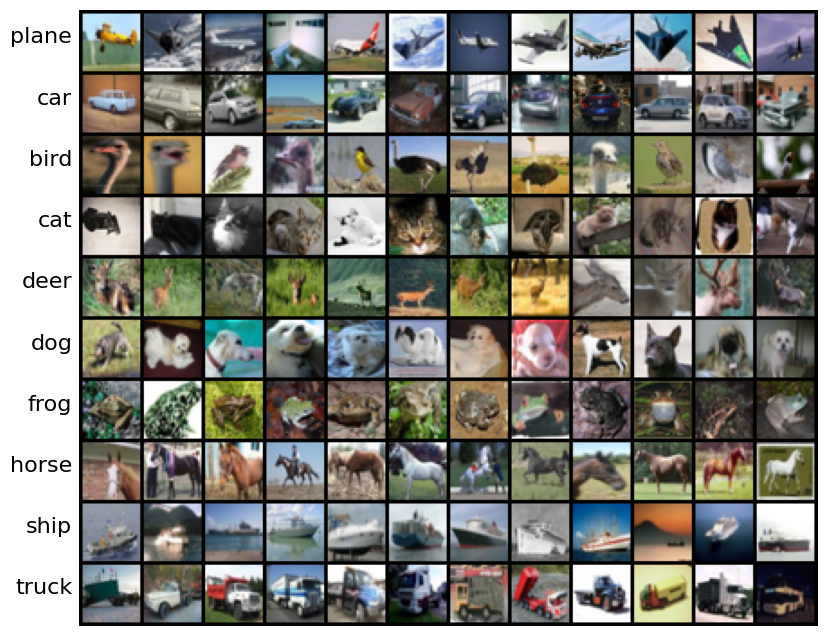

Train data shape:  torch.Size([40000, 3072])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3072])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3072])
Test labels shape:  torch.Size([10000])


In [3]:
import utils

reset_seed(0)
data_dict = utils.preprocess_cifar10(cuda=False, dtype=torch.float64)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

# Fully-connected neural networks
이전 과제에서는 CIFAR-10에 대해 fully-connected two-layer neural network를 구현했습니다.  
하지만 이전 코드들은 loss와 gradient를 하나의 함수에서 계산했기 때문에 모듈성이 높지 않습니다. 이는 더 큰 모델로 갈수록 비효율적인 구현이라고 할 수 있겠습니다.  

이상적으로는 모듈식(modular) 설계로 네트워크를 만드는 것이 좋습니다.  
서로 다른 layer 타입을 각각 독립적으로 구현한 뒤 이를 조합해 다양한 아키텍처의 모델을 구성할 수 있어야 합니다.

여기서는 fully-connected networks를 더 모듈식 접근 방식으로 구현합니다.  
이를 위해 각 layer 구현체에서 `forward`와 `backward` 함수를 구현합니다.  

`forward` 함수는 입력, weights, 다른 파라미터들을 받아서 출력값(out)과 backward pass에 필요한 데이터를 저장하는 `cache` 객체를 함께 반환합니다.

```python
def forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

backward pass는 upstream derivatives와 `cache` 객체를 입력으로 받아, 입력과 weights에 대한 gradients를 반환합니다.    
수업 때 배운 backpropagation을 잘 기억해보세요.

```python
def backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

이와 같은 방식으로 여러 layer들을 구현하면 서로 조합해 다양한 아키텍처의 classifier를 손쉽게 만들 수 있습니다.

# Linear (fully-connected) layer

각 layer를 구현할 때는 `forward`와 `backward` 두 개의 static method를 가진 class를 정의합니다.  
class는 `fully_connected_layers.py`에 제공되어 있으며 여기서 `forward`와 `backward` 메서드를 모두 구현해야 합니다.

## 구현 하기: Linear layer (forward)
`fully_connected_layers.py`에서 `Linear.forward` 메서드를 구현하세요.  
구현을 마친 후 다음 코드 셀을 실행할 때 오차가 `1e-7` 이하로 나와야 합니다.

In [4]:
from fully_connected_networks import Linear

# Test the Linear.forward function
num_inputs = 2
input_shape = torch.tensor((4, 5, 6))
output_dim = 3

input_size = num_inputs * torch.prod(input_shape)
weight_size = output_dim * torch.prod(input_shape)

x = torch.linspace(-0.1, 0.5, steps=input_size, dtype=torch.float64, device='cpu')
w = torch.linspace(-0.2, 0.3, steps=weight_size, dtype=torch.float64, device='cpu')
b = torch.linspace(-0.3, 0.1, steps=output_dim, dtype=torch.float64, device='cpu')
x = x.reshape(num_inputs, *input_shape)
w = w.reshape(torch.prod(input_shape), output_dim)

out, _ = Linear.forward(x, w, b)
correct_out = torch.tensor([[1.49834984, 1.70660150, 1.91485316],
                            [3.25553226, 3.51413301, 3.77273372]]
                            ).double()

print('Testing Linear.forward function:')
print('difference: ', utils.rel_error(out, correct_out))

Testing Linear.forward function:
difference:  3.683042917976506e-08


## 구현 하기: Linear layer (backward)
마찬가지로 `Linear.backward` 메서드를 구현하세요.  
구현을 마친 후 다음 코드 셀을 실행할 때 모든 derivation의 오차가 `1e-7` 이하로 나와야 합니다.

In [5]:
from fully_connected_networks import Linear

# Test the Linear.backward function
reset_seed(0)
x = torch.randn(10, 2, 3, dtype=torch.float64, device='cpu')
w = torch.randn(6, 5, dtype=torch.float64, device='cpu')
b = torch.randn(5, dtype=torch.float64, device='cpu')
dout = torch.randn(10, 5, dtype=torch.float64, device='cpu')

dx_num = utils.compute_numeric_gradient(lambda x: Linear.forward(x, w, b)[0], x, dout)
dw_num = utils.compute_numeric_gradient(lambda w: Linear.forward(x, w, b)[0], w, dout)
db_num = utils.compute_numeric_gradient(lambda b: Linear.forward(x, w, b)[0], b, dout)

_, cache = Linear.forward(x, w, b)
dx, dw, db = Linear.backward(dout, cache)

# The error should be around e-10 or less
print('Testing Linear.backward function:')
print('dx error: ', utils.rel_error(dx_num, dx))
print('dw error: ', utils.rel_error(dw_num, dw))
print('db error: ', utils.rel_error(db_num, db))

Testing Linear.backward function:
dx error:  1.0798034493291739e-09
dw error:  6.130641106419102e-10
db error:  5.864914880269229e-10


# ReLU activation

## 구현 하기 ReLU activation (forward)
`ReLU.forward` 함수에서 ReLU activation function의 forward pass를 구현하세요.  
이때 입력 tensor를 in-place 연산으로 변경해서는 안 됩니다.

구현을 마친 뒤 아래 코드를 실행해 ReLU forward pass를 테스트하세요.  
오차는 `1e-7` 이하이어야 합니다.

In [6]:
from fully_connected_networks import ReLU

reset_seed(0)
x = torch.linspace(-0.5, 0.5, steps=12, dtype=torch.float64, device='cpu')
x = x.reshape(3, 4)

out, _ = ReLU.forward(x)
correct_out = torch.tensor([[ 0.,          0.,          0.,          0.,        ],
                            [ 0.,          0.,          0.04545455,  0.13636364,],
                            [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]],
                            dtype=torch.float64,
                            device='cpu')

# Compare your output with ours. The error should be on the order of e-8
print('Testing ReLU.forward function:')
print('difference: ', utils.rel_error(out, correct_out))

Testing ReLU.forward function:
difference:  4.545454589111042e-09


## 구현 하기: ReLU activation (backward)
이제 ReLU activation function의 backward pass를 구현하세요.
이번에도 입력 tensor를 in-place 연산으로 변경하면 안 됩니다.

구현을 마친 뒤 아래 코드를 실행해 `ReLU.backward`를 테스트하세요.  
오차는 `1e-8` 이하이어야 합니다.

In [7]:
from fully_connected_networks import ReLU

reset_seed(0)
x = torch.randn(10, 10, dtype=torch.float64, device='cpu')
dout = torch.randn(*x.shape, dtype=torch.float64, device='cpu')

dx_num = utils.compute_numeric_gradient(lambda x: ReLU.forward(x)[0], x, dout)

_, cache = ReLU.forward(x)
dx = ReLU.backward(dout, cache)

# The error should be on the order of e-12
print('Testing ReLU.backward function:')
print('dx error: ', utils.rel_error(dx_num, dx))

Testing ReLU.backward function:
dx error:  2.919336055418408e-10


# "Sandwich" layers
Neural net을 구현할 때 자주 사용되는 layer 패턴들이 있습니다. 예를 들어 linear layer 다음에 ReLU가 바로 오는 경우는 매우 흔합니다.<br>
이런 패턴을 쉽게 쓰기 위해 편의(convenience) layer를 정의합니다.

이렇게 구현하는 방식은 기존 layer 구현을 조합해 새로운 layer를 만들 수 있음을 보여줍니다. 이는 딥러닝 코드를 모듈식으로 구성하는 데 유용한 방법입니다.

지금은 `Linear_ReLU`의 `forward`, `backward` 함수를 살펴보고, 아래 코드 셀을 실행해 backward pass에 대해 numeric gradient check를 수행하세요.<br>
아래 코드를 실행해 `Linear_ReLU` layer 구현을 numeric gradient checking으로 테스트해 보세요.  
오차는 `1e-8` 이하이어야 합니다.

In [8]:
from fully_connected_networks import Linear_ReLU

reset_seed(0)
x = torch.randn(2, 3, 4, dtype=torch.float64, device='cpu')
w = torch.randn(12, 10, dtype=torch.float64, device='cpu')
b = torch.randn(10, dtype=torch.float64, device='cpu')
dout = torch.randn(2, 10, dtype=torch.float64, device='cpu')

out, cache = Linear_ReLU.forward(x, w, b)
dx, dw, db = Linear_ReLU.backward(dout, cache)

dx_num = utils.compute_numeric_gradient(lambda x: Linear_ReLU.forward(x, w, b)[0], x, dout)
dw_num = utils.compute_numeric_gradient(lambda w: Linear_ReLU.forward(x, w, b)[0], w, dout)
db_num = utils.compute_numeric_gradient(lambda b: Linear_ReLU.forward(x, w, b)[0], b, dout)

# Relative error should be around e-8 or less
print('Testing Linear_ReLU.forward and Linear_ReLU.backward:')
print('dx error: ', utils.rel_error(dx_num, dx))
print('dw error: ', utils.rel_error(dw_num, dw))
print('db error: ', utils.rel_error(db_num, db))

Testing Linear_ReLU.forward and Linear_ReLU.backward:
dx error:  1.0072034782327402e-09
dw error:  9.907273332982295e-10
db error:  1.2138260003566626e-09


# 구현 하기: Two-layer network
이전 구현에서는 두 개의 layer를 하나의 큰 class에 모두 구현했습니다.  
이제 필요한 layer들을 모듈식으로 구현했으니 이걸 사용해 two-layer network를 다시 구현하겠습니다.

`TwoLayerNet` class의 구현을 완성하세요.  
two-layer net의 forward와 backward pass를 모두 구현했다면, 아래 코드를 실행해 구현을 테스트하세요.

In [10]:
from fully_connected_networks import TwoLayerNet, softmax_loss

reset_seed(0)
N, D, H, C = 3, 5, 50, 7
X = torch.randn(N, D, dtype=torch.float64, device='cpu')
y = torch.randint(C, size=(N,), dtype=torch.int64, device='cpu')

std = 1e-3
model = TwoLayerNet(
          input_dim=D,
          hidden_dim=H,
          num_classes=C,
          weight_scale=std,
          dtype=torch.float64,
          device='cpu'
        )

print('Testing initialization ... ')
W1_std = torch.abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = torch.abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert torch.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert torch.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = torch.linspace(-0.7, 0.3, steps=D * H, dtype=torch.float64, device='cpu').reshape(D, H)
model.params['b1'] = torch.linspace(-0.1, 0.9, steps=H, dtype=torch.float64, device='cpu')
model.params['W2'] = torch.linspace(-0.3, 0.4, steps=H * C, dtype=torch.float64, device='cpu').reshape(H, C)
model.params['b2'] = torch.linspace(-0.9, 0.1, steps=C, dtype=torch.float64, device='cpu')
X = torch.linspace(-5.5, 4.5, steps=N * D, dtype=torch.float64, device='cpu').reshape(D, N).t()
scores = model.loss(X)
correct_scores = torch.tensor(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]],
    dtype=torch.float64, device='cpu')
scores_diff = torch.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = torch.tensor([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 49.719461034881775
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-6 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = utils.compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, utils.rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 2.29e-07
W2 relative error: 1.49e-09
b1 relative error: 6.47e-07
b2 relative error: 3.67e-09
Running numeric gradient check with reg =  0.7
W1 relative error: 3.07e-08
W2 relative error: 1.03e-08
b1 relative error: 6.27e-07
b2 relative error: 2.72e-08


# 구현 하기: Solver
이전 구현에서는 모델 학습 로직이 모델 class 내부에 함께 들어 있었습니다.  
그런데 실제로 구현할 때는 학습과 모델 정의를 따로 분리해놓는게 좋습니다.<br>
이번 구현에서는 더 모듈식 설계를 따르기 위해 모델 학습 로직을 별도의 class로 분리했습니다.

이렇게 학습을 해주는 class를 사람들은 trainer 혹은 solver라고 많이들 부릅니다.

`Solver` class를 사용해 `TwoLayerNet`을 학습시키는 solver 인스턴스를 만들고, validation set에서 최소 50% 성능을 달성하세요. 
`Solver` class의 사용 방법을 숙지하고 `create_solver_instance` 함수를 작성하면 됩니다.

In [19]:
from fully_connected_networks import create_solver_instance

reset_seed(0)

# Create a solver instance that achieves 50% performance on the validation set
solver = create_solver_instance(data_dict=data_dict, dtype=torch.float64, device='cpu')
solver.train()


(Time 0.01 sec; Iteration 1 / 11875) loss: 2.302590
(Epoch 0 / 19) train acc: 0.107000; val_acc: 0.101600
(Time 1.24 sec; Iteration 101 / 11875) loss: 1.961258
(Time 2.21 sec; Iteration 201 / 11875) loss: 1.838029
(Time 3.15 sec; Iteration 301 / 11875) loss: 2.026528
(Time 4.09 sec; Iteration 401 / 11875) loss: 1.581808
(Time 5.11 sec; Iteration 501 / 11875) loss: 2.034385
(Time 6.06 sec; Iteration 601 / 11875) loss: 1.798004
(Epoch 1 / 19) train acc: 0.387000; val_acc: 0.371900
(Time 7.20 sec; Iteration 701 / 11875) loss: 1.927463
(Time 8.16 sec; Iteration 801 / 11875) loss: 1.896349
(Time 9.12 sec; Iteration 901 / 11875) loss: 1.657012
(Time 10.13 sec; Iteration 1001 / 11875) loss: 1.773437
(Time 11.07 sec; Iteration 1101 / 11875) loss: 1.736966
(Time 12.03 sec; Iteration 1201 / 11875) loss: 1.549482
(Epoch 2 / 19) train acc: 0.457000; val_acc: 0.394900
(Time 13.12 sec; Iteration 1301 / 11875) loss: 1.483135
(Time 14.02 sec; Iteration 1401 / 11875) loss: 1.418664
(Time 14.93 sec; Ite

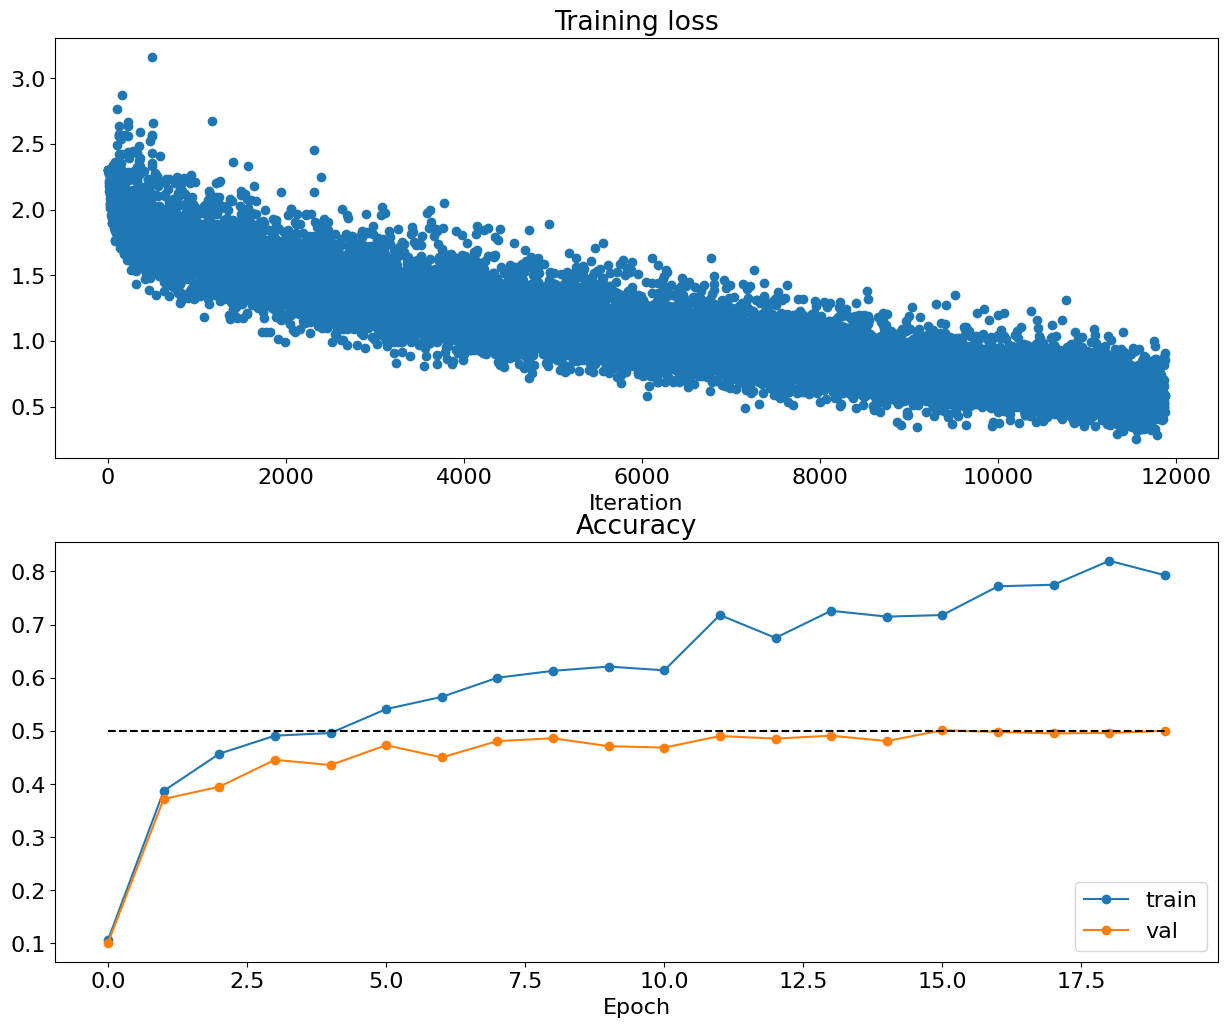

In [20]:
# Run this cell to visualize training loss and train / val accuracy
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

모델의 성능이 잘 나온다면 아래 코드 셀을 실행해 모델을 저장할 수 있습니다.  
이후 저장된 모델을 다시 불러와 validation 데이터셋에서 검증할 수 있습니다.

In [60]:
path = 'best_two_layer_net.pth'
solver.model.save(path)

# Create a new instance
from fully_connected_networks import create_solver_instance
reset_seed(0)

solver = create_solver_instance(data_dict=data_dict, dtype=torch.float64, device='cpu')

# Load model
solver.model.load(path, dtype=torch.float64, device='cpu')

# Evaluate on validation set
accuracy = solver.check_accuracy(solver.X_val, solver.y_val)
print(f"Saved model's accuracy on validation is {accuracy}")


Saved in best_two_layer_net.pth
load checkpoint file: best_two_layer_net.pth
Saved model's accuracy on validation is 0.10140000283718109


# 구현 하기: Multilayer (다층) network
이제 여러개의 hidden layer를 가진 fully-connected network를 구현합니다.

`fully_connected_networks.py`의 `FullyConnectedNet` class를 보고 initialization(초기화), forward pass, backward pass를 구현하세요.  

## Initial loss and gradient check

sanity check를 위해 아래 코드를 실행해 초기 loss를 확인하고 regularization을 켠 경우와 끈 경우 모두에 대해 네트워크의 gradient check를 수행하세요.  
gradient checking에서는 대부분의 항목에서 오류가 `1e-6`보다 작아야 합니다.  
단, `reg=0`에서 `W1`과 `W2`에 대한 체크는 오류가 `1e-5`보다 작아야 합니다.

In [25]:
from fully_connected_networks import FullyConnectedNet

reset_seed(0)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = torch.randn(N, D, dtype=torch.float64, device='cpu')
y = torch.randint(C, size=(N,), dtype=torch.int64, device='cpu')

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet(
        [H1, H2], 
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2, 
        dtype=torch.float64, 
        device='cpu'
  )

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss.item())

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = utils.compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, utils.rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3017956720294004
W1 relative error: 1.35e-07
W2 relative error: 8.28e-08
W3 relative error: 3.74e-08
b1 relative error: 1.33e-07
b2 relative error: 2.73e-08
b3 relative error: 5.77e-09
Running check with reg =  3.14
Initial loss:  11.790288542569861
W1 relative error: 9.64e-09
W2 relative error: 1.25e-08
W3 relative error: 1.08e-08
b1 relative error: 2.95e-07
b2 relative error: 5.58e-08
b3 relative error: 7.37e-09


또 다른 sanity check로 50장의 매우 작은 데이터셋에 대해 overfitting이 가능한지 확인해 보세요.  
먼저 hidden layer마다 100개의 unit을 가진 three-layer network를 시도합니다.  

아래 셀에서 **learning rate**와 **weight initialization scale**을 조정해, 20 epoch 이내에 training accuracy가 100%에 도달하도록 overfit을 만들어 보세요 (validation accuracy가 아니니까 주의하세요).
<br>
만약 아무리해도 overfitting이 일어나지 않는다면 구현이 잘못되었다고 의심할 수 있습니다.

(Time 0.00 sec; Iteration 1 / 40) loss: 2.323959
(Epoch 0 / 20) train acc: 0.440000; val_acc: 0.129000
(Epoch 1 / 20) train acc: 0.440000; val_acc: 0.125200
(Epoch 2 / 20) train acc: 0.360000; val_acc: 0.112800
(Epoch 3 / 20) train acc: 0.440000; val_acc: 0.147700
(Epoch 4 / 20) train acc: 0.520000; val_acc: 0.150700
(Epoch 5 / 20) train acc: 0.640000; val_acc: 0.174100
(Time 0.53 sec; Iteration 11 / 40) loss: 1.239391
(Epoch 6 / 20) train acc: 0.520000; val_acc: 0.176800
(Epoch 7 / 20) train acc: 0.600000; val_acc: 0.143200
(Epoch 8 / 20) train acc: 0.760000; val_acc: 0.162800
(Epoch 9 / 20) train acc: 0.840000; val_acc: 0.191000
(Epoch 10 / 20) train acc: 0.880000; val_acc: 0.188800
(Time 1.07 sec; Iteration 21 / 40) loss: 0.523707
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.159000
(Epoch 12 / 20) train acc: 0.900000; val_acc: 0.162200
(Epoch 13 / 20) train acc: 0.940000; val_acc: 0.167200
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.187500
(Epoch 15 / 20) train acc: 1.000000;

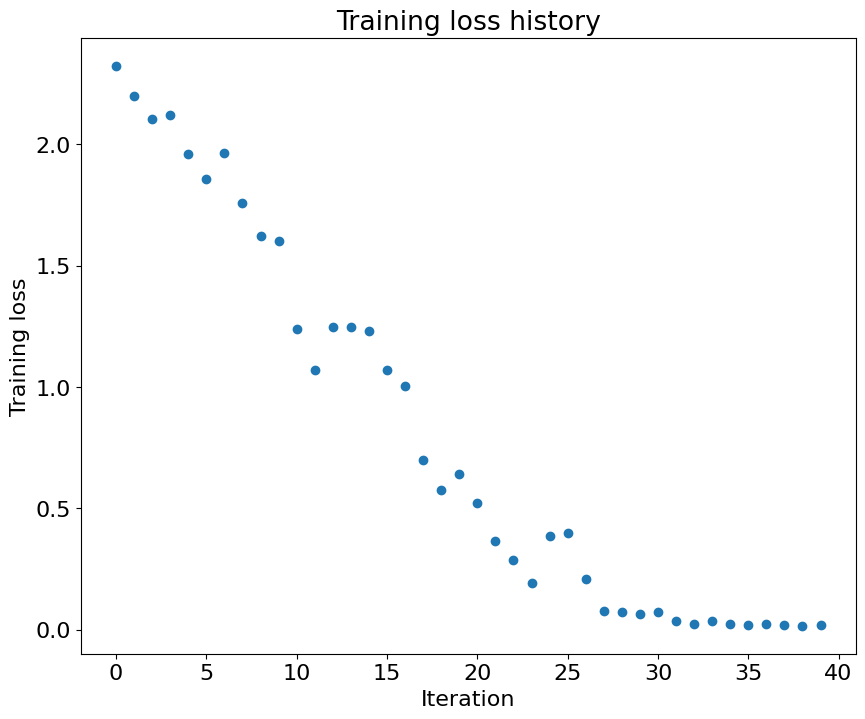

In [44]:
from fully_connected_networks import FullyConnectedNet, get_three_layer_network_params

# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.
reset_seed(0)

num_train = 50
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

# Update parameters in get_three_layer_network_params
weight_scale, learning_rate = get_three_layer_network_params()

model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=torch.float32, device='cpu')
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cpu',
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

이번에는 각 layer에 100개의 unit을 가진 five-layer network를 사용해, 50개의 training 예제를 overfit시켜 보세요.  
마찬가지로 **learning rate**와 **weight initialization scale**을 조정해야 하지만, 20 epoch 이내에 training accuracy 100%를 달성할 수 있어야 합니다.

(Time 0.00 sec; Iteration 1 / 40) loss: 2.287230
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.123300
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.124700
(Epoch 2 / 20) train acc: 0.200000; val_acc: 0.108800
(Epoch 3 / 20) train acc: 0.280000; val_acc: 0.126200
(Epoch 4 / 20) train acc: 0.340000; val_acc: 0.133700
(Epoch 5 / 20) train acc: 0.260000; val_acc: 0.123600
(Time 0.63 sec; Iteration 11 / 40) loss: 1.869117
(Epoch 6 / 20) train acc: 0.360000; val_acc: 0.142500
(Epoch 7 / 20) train acc: 0.360000; val_acc: 0.150100
(Epoch 8 / 20) train acc: 0.500000; val_acc: 0.159600
(Epoch 9 / 20) train acc: 0.460000; val_acc: 0.161200
(Epoch 10 / 20) train acc: 0.680000; val_acc: 0.169300
(Time 1.15 sec; Iteration 21 / 40) loss: 0.990058
(Epoch 11 / 20) train acc: 0.560000; val_acc: 0.162600
(Epoch 12 / 20) train acc: 0.660000; val_acc: 0.160100
(Epoch 13 / 20) train acc: 0.820000; val_acc: 0.169100
(Epoch 14 / 20) train acc: 0.920000; val_acc: 0.190100
(Epoch 15 / 20) train acc: 0.920000;

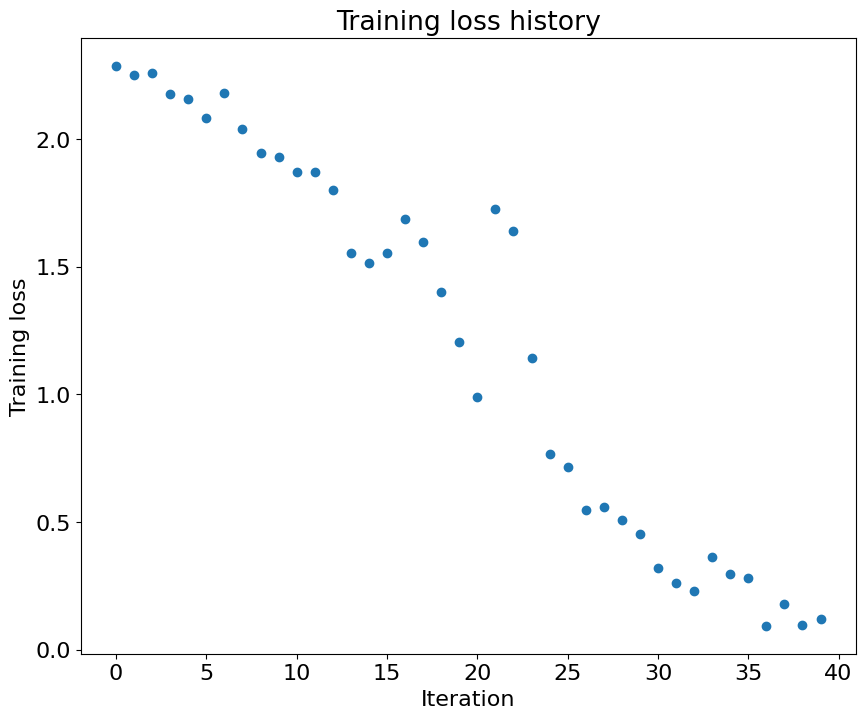

In [71]:
from fully_connected_networks import FullyConnectedNet, get_five_layer_network_params

# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.
reset_seed(0)

num_train = 50
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}


# Update parameters in get_three_layer_network_params
weight_scale, learning_rate = get_five_layer_network_params()

# Run models and solver with parameters
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=torch.float32, device='cpu')
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cpu',
         )
# Turn off keep_best_params to allow final weights to be saved, instead of best weights on validation set.
solver.train(return_best_params=False)

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

모델의 성능이 만족스럽다면 overfit된 모델을 저장하세요.  
sanity check를 위해 저장한 모델을 다시 training set에서 평가해, 저장된 weights가 성능을 내는지 확인합니다.

In [72]:
# Set path 
path = 'best_overfit_five_layer_net.pth'
solver.model.save(path)


# Create a new instance  -- Note that hidden dims being different doesn't matter here.
model = FullyConnectedNet(hidden_dims=[100, ], dtype=torch.float32, device='cpu')
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cpu',
         )


# Load model
solver.model.load(path, dtype=torch.float32, device='cpu')

# Evaluate on validation set
accuracy = solver.check_accuracy(solver.X_train, solver.y_train)
print(f"Saved model's accuracy on small train is {accuracy}")


Saved in best_overfit_five_layer_net.pth
load checkpoint file: best_overfit_five_layer_net.pth
Saved model's accuracy on small train is 1.0


# Update rules
지금까지는 update rule로 기본 stochastic gradient descent(SGD)만 사용했습니다.  
하지만 수업 때 배운것과 같이 더 발전된 update rule을 사용하면 모델 학습이 더 쉬워질 수 있습니다.  

이제 자주 사용되는 몇 가지 update rule을 구현하고, 이를 vanilla SGD와 비교해 보겠습니다.

## 구현 하기: SGD+Momentum
우리가 구현할 모든 update rule은 동일한 인터페이스를 가집니다:

```python
def update(w, dw, config=None):
Inputs:
  - w: A tensor giving the current weights.
  - dw: A tensor of the same shape as w giving the gradient of the
    loss with respect to w.
  - config: A dictionary containing hyperparameter values such as learning
    rate, momentum, etc. If the update rule requires caching values over many
    iterations, then config will also hold these cached values.
Returns:
  - next_w: The next point after the update.
  - config: The config dictionary to be passed to the next iteration of the
    update rule.
NOTE: For most update rules, the default learning rate will probably not
perform well; however the default values of the other hyperparameters should
work well for a variety of different problems.
For efficiency, update rules may perform in-place updates, mutating w and
setting next_w equal to w.
```

`fully_connected_networks.py`에 참고용으로 SGD update rule 구현을 제공했습니다.

이제 같은 인터페이스로 SGD+Momentum update rule을 구현하고 아래 코드 셀을 실행하세요. 오차는 `1e-7` 이하이어야 합니다.

In [74]:
from fully_connected_networks import sgd_momentum

reset_seed(0)

N, D = 4, 5
w = torch.linspace(-0.4, 0.6, steps=N*D, dtype=torch.float64, device='cpu').reshape(N, D)
dw = torch.linspace(-0.6, 0.4, steps=N*D, dtype=torch.float64, device='cpu').reshape(N, D)
v = torch.linspace(0.6, 0.9, steps=N*D, dtype=torch.float64, device='cpu').reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = torch.tensor([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]],
   dtype=torch.float64, device='cpu')
expected_velocity = torch.tensor([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]],
   dtype=torch.float64, device='cpu')

# Should see relative errors around e-8 or less
print('next_w error: ', utils.rel_error(next_w, expected_next_w))
print('velocity error: ', utils.rel_error(expected_velocity, config['velocity']))

next_w error:  1.6802078709310813e-09
velocity error:  2.9254212825785614e-09


이제 SGD와 SGD+Momentum을 사용해서 네트워크를 학습합니다.   
Momentum을 사용한 경우 더 학습이 빠르게 되는것을 볼 수 있습니다.

running with  sgd
(Time 0.01 sec; Iteration 1 / 200) loss: 2.302626
(Epoch 0 / 5) train acc: 0.097000; val_acc: 0.100700
(Epoch 1 / 5) train acc: 0.096000; val_acc: 0.100400
(Epoch 2 / 5) train acc: 0.134000; val_acc: 0.117600
(Epoch 3 / 5) train acc: 0.114000; val_acc: 0.100300
(Epoch 4 / 5) train acc: 0.095000; val_acc: 0.099400
(Epoch 5 / 5) train acc: 0.093000; val_acc: 0.092200

running with  sgd_momentum
(Time 0.01 sec; Iteration 1 / 200) loss: 2.302484
(Epoch 0 / 5) train acc: 0.071000; val_acc: 0.074100
(Epoch 1 / 5) train acc: 0.105000; val_acc: 0.099700
(Epoch 2 / 5) train acc: 0.154000; val_acc: 0.151900
(Epoch 3 / 5) train acc: 0.170000; val_acc: 0.163600
(Epoch 4 / 5) train acc: 0.264000; val_acc: 0.247100
(Epoch 5 / 5) train acc: 0.306000; val_acc: 0.266000



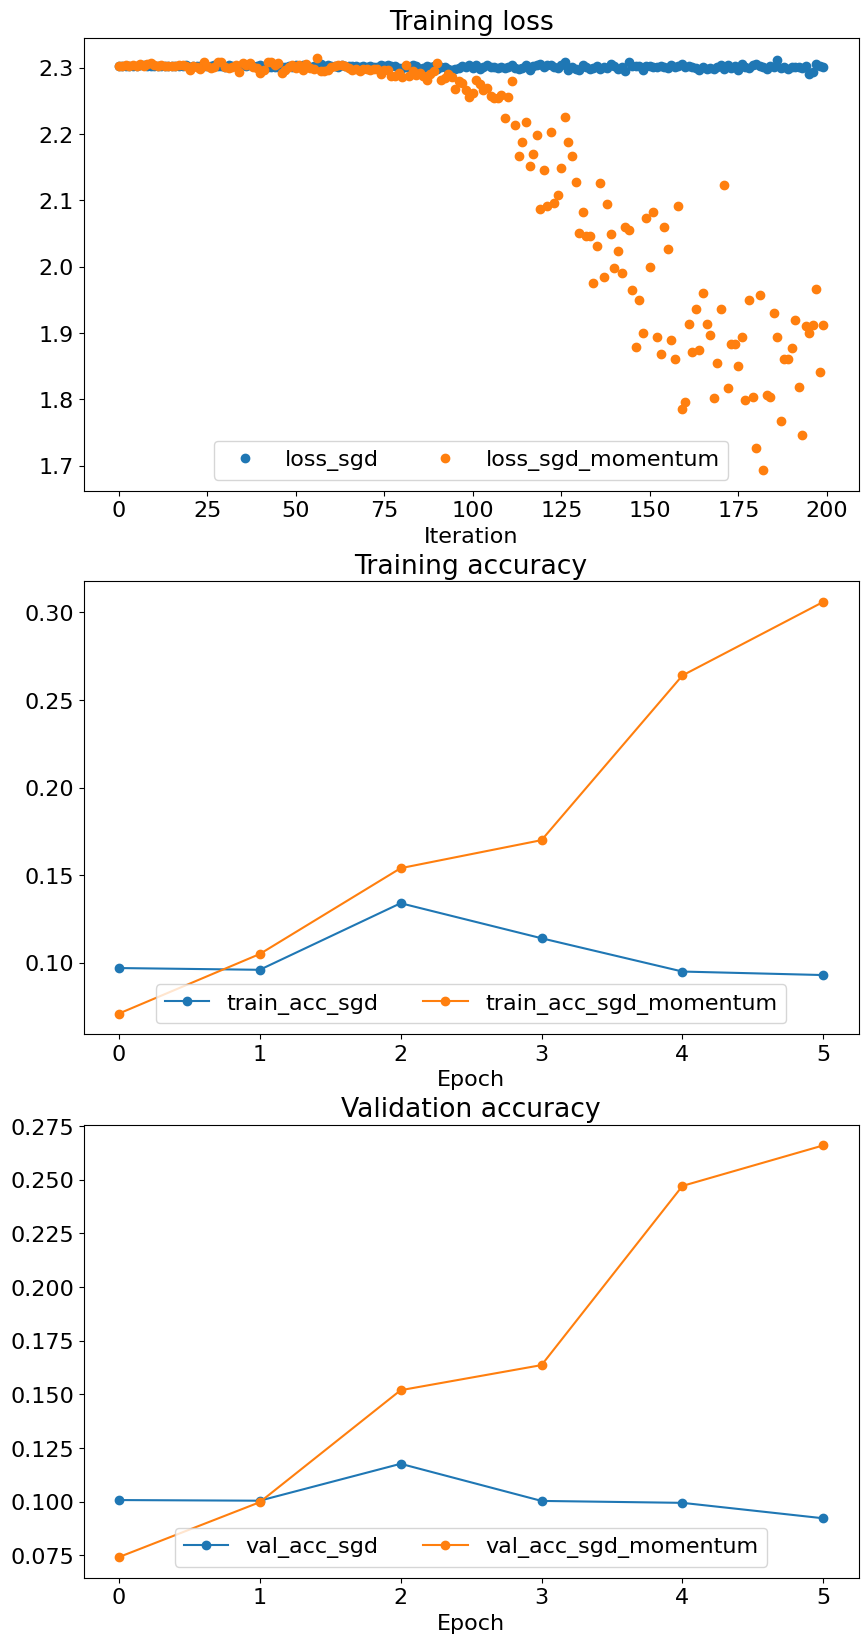

In [75]:
from fully_connected_networks import FullyConnectedNet, sgd, sgd_momentum

# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.
reset_seed(0)

num_train = 4000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

solvers = {}

for update_rule_name, update_rule_fn in [('sgd', sgd), ('sgd_momentum', sgd_momentum)]:
  print('running with ', update_rule_name)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2,
                            dtype=torch.float32, device='cpu')

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule_fn,
                  optim_config={
                    'learning_rate': 5e-2,
                  },
                  print_every=1000,
                  verbose=True,
                  device='cpu')
  solvers[update_rule_name] = solver
  solver.train()
  print()
  
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
for update_rule, solver in solvers.items():
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
plt.legend(loc='lower center', ncol=4)
  
plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')
for update_rule, solver in solvers.items():
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)
plt.legend(loc='lower center', ncol=4)

  
plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
for update_rule, solver in solvers.items():
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
plt.legend(loc='lower center', ncol=4)

plt.gcf().set_size_inches(10, 20)
plt.show()

## 구현 하기: RMSProp

`fully_connected_networks.py`의 `rmsprop` 함수에서 RMSProp update rule을 구현하세요.  
구현을 마친 뒤 아래 코드를 실행해 RMSProp 구현을 테스트하세요. 오차는 `1e-6` 이하이어야 합니다.

In [76]:
# Test RMSProp implementation
from fully_connected_networks import rmsprop

reset_seed(0)

N, D = 4, 5
w = torch.linspace(-0.4, 0.6, steps=N*D, dtype=torch.float64, device='cpu').reshape(N, D)
dw = torch.linspace(-0.6, 0.4, steps=N*D, dtype=torch.float64, device='cpu').reshape(N, D)
cache = torch.linspace(0.6, 0.9, steps=N*D, dtype=torch.float64, device='cpu').reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = torch.tensor([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]],
   dtype=torch.float64, device='cpu')
expected_cache = torch.tensor([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]],
   dtype=torch.float64, device='cpu')

print('next_w error: ', utils.rel_error(expected_next_w, next_w))
print('cache error: ', utils.rel_error(expected_cache, config['cache']))

next_w error:  4.064797880829826e-09
cache error:  1.8620321382570356e-09


## 구현 하기 Adam
마찬가지로 Adam 기법을 구현합니다.
`next_w`의 error는 `1e-6` 미만, `v`와 `m`의 error는 `1e-8` 미만이어야 합니다.

주의 사항: bias correction 까지 구현해야 합니다.

In [77]:
# Test Adam implementation
from fully_connected_networks import adam

reset_seed(0)

N, D = 4, 5
w = torch.linspace(-0.4, 0.6, steps=N*D, dtype=torch.float64, device='cpu').reshape(N, D)
dw = torch.linspace(-0.6, 0.4, steps=N*D, dtype=torch.float64, device='cpu').reshape(N, D)
m = torch.linspace(0.6, 0.9, steps=N*D, dtype=torch.float64, device='cpu').reshape(N, D)
v = torch.linspace(0.7, 0.5, steps=N*D, dtype=torch.float64, device='cpu').reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = torch.tensor([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]],
   dtype=torch.float64, device='cpu')
expected_v = torch.tensor([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]],
   dtype=torch.float64, device='cpu')
expected_m = torch.tensor([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]],
   dtype=torch.float64, device='cpu')

# You should see relative errors around e-7 or less
print('next_w error: ', utils.rel_error(expected_next_w, next_w))
print('v error: ', utils.rel_error(expected_v, config['v']))
print('m error: ', utils.rel_error(expected_m, config['m']))

next_w error:  3.756728297598868e-09
v error:  3.4048987160545265e-09
m error:  2.7863777951608877e-09


이제 두 최적화 기법을 통해서 모델을 학습해봅시다.

running with  sgd_momentum
(Time 0.01 sec; Iteration 1 / 200) loss: 2.302626
(Epoch 0 / 5) train acc: 0.154000; val_acc: 0.147100
(Epoch 1 / 5) train acc: 0.281000; val_acc: 0.247900
(Epoch 2 / 5) train acc: 0.293000; val_acc: 0.287400
(Epoch 3 / 5) train acc: 0.363000; val_acc: 0.326300
(Epoch 4 / 5) train acc: 0.402000; val_acc: 0.343700
(Epoch 5 / 5) train acc: 0.459000; val_acc: 0.351500

running with  sgd_momentum
(Time 0.01 sec; Iteration 1 / 200) loss: 2.302484
(Epoch 0 / 5) train acc: 0.129000; val_acc: 0.132400
(Epoch 1 / 5) train acc: 0.238000; val_acc: 0.210000
(Epoch 2 / 5) train acc: 0.272000; val_acc: 0.254600
(Epoch 3 / 5) train acc: 0.274000; val_acc: 0.259100
(Epoch 4 / 5) train acc: 0.274000; val_acc: 0.261600
(Epoch 5 / 5) train acc: 0.305000; val_acc: 0.264800



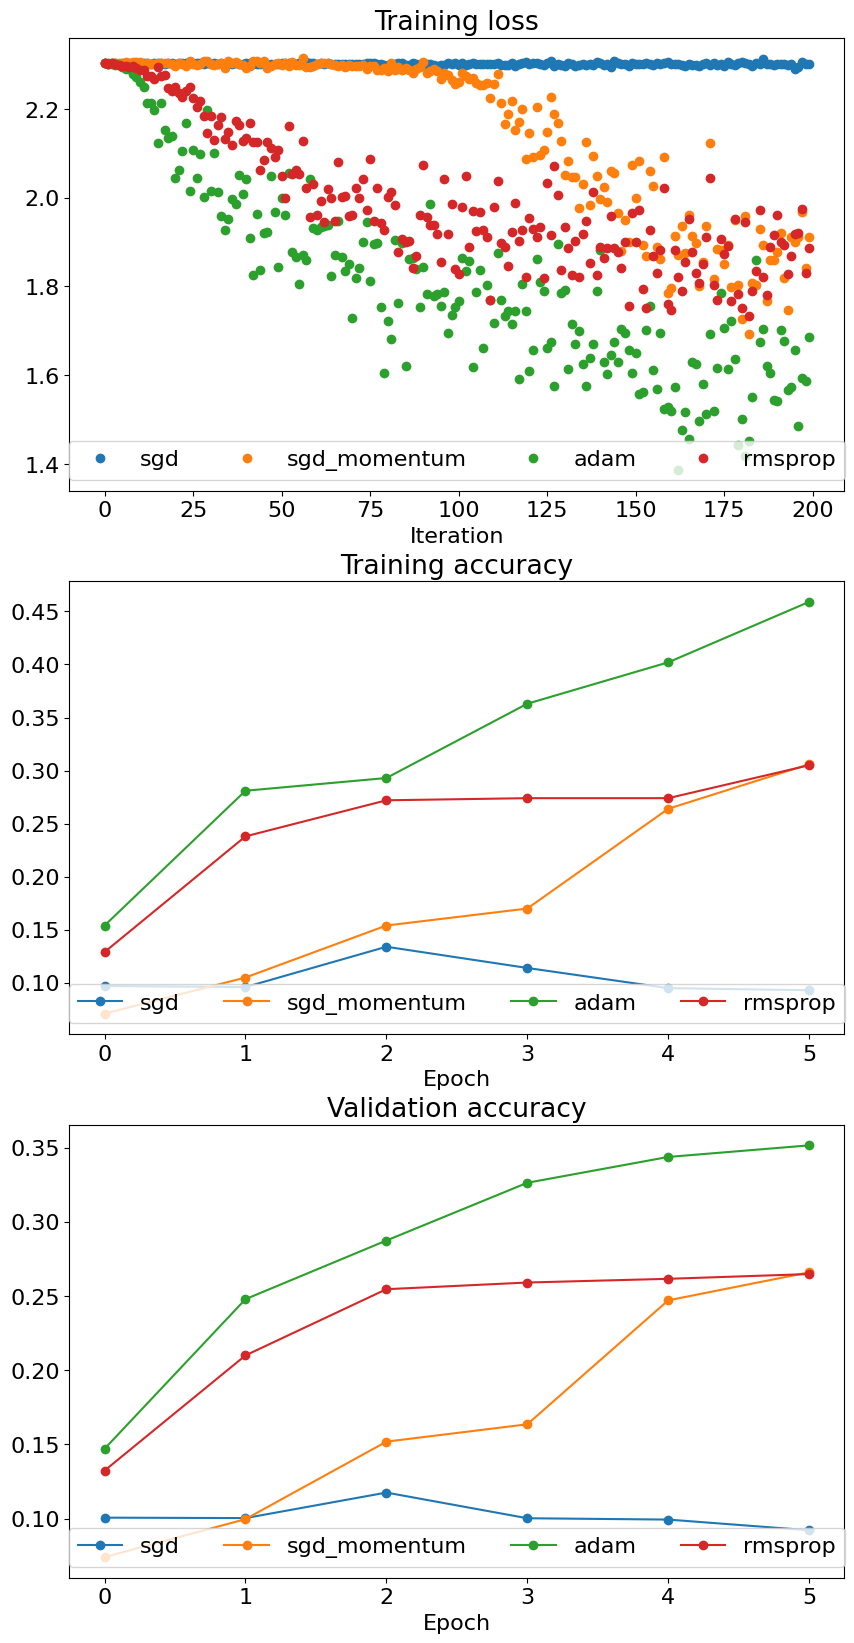

In [78]:
# Test Adam implementation
from fully_connected_networks import adam, rmsprop, FullyConnectedNet

for update_rule_name, update_rule_fn, learning_rate in [('adam', adam, 1e-3), ('rmsprop', rmsprop, 1e-4)]:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2, device='cpu')

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule_fn,
                  optim_config={
                    'learning_rate': learning_rate
                  },
                  print_every=1000,
                  verbose=True, device='cpu')
  solvers[update_rule_name] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.loss_history, 'o', label=update_rule)
plt.legend(loc='lower center', ncol=4)
  
plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.train_acc_history, '-o', label=update_rule)
plt.legend(loc='lower center', ncol=4)

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
plt.legend(loc='lower center', ncol=4)

plt.gcf().set_size_inches(10, 20)
plt.show()